<a href="https://colab.research.google.com/github/anamilanezi/ebac-dados/blob/main/projetos/em17-analise-exploratoria-python-II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística I
Caderno de **Exercícios**<br> 
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **1\. Contexto**

Neste problema, iremos utilizar os dados sintetizados de fontes públicas (IBGE, IPEA, etc.) que são representativos dos desafios que a startup Loggi enfrenta no dia a dia, como otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada, etc. O dado bruto é um arquivo do tipo JSON com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional.

Os dados estão organizados da seguinte forma:
 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas:
    - **id**: uma `string` com o id único da **entrega**;
    - **point**: um `dict` com a latitude e longitude da **entrega**;
    - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.


# **2\. Pacotes e bibliotecas**

In [1]:
!pip install geopandas
!pip install h3

import json
import pandas as pd
import geopandas
import h3
from pprint import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.4 MB/s eta 0:00:00


# **3\. Exploração de dados**

## **3.1. Coleta**

Obtendo os dados brutos no formato `.json`:

In [2]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

In [3]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [4]:
# Formato do dado coletado:
type(data)

list

In [5]:
# Quantidade de itens da lista
len(data)

199

In [6]:
# Atribuindo o primeiro item da lista a uma variável para verificar sua organização
primeiro_item = data[0]
pprint(primeiro_item, depth=1)

{'deliveries': [...],
 'name': 'cvrp-2-df-33',
 'origin': {...},
 'region': 'df-2',
 'vehicle_capacity': 180}


In [7]:
def print_dic(itemsDict, leftWidth, rightWidth, values=True):
  print(' TIPOS DE DADOS '.center(leftWidth + rightWidth, '-'))
  if values:
    for k, v in itemsDict.items():
      print(f"'{k}'".ljust(leftWidth, '.') + f'{v}'.ljust(rightWidth))
  else:
    for k, v in itemsDict.items():
      print(f"'{k}'".ljust(leftWidth, '.') + f'{type(v)}'.ljust(rightWidth))

👉 Cada item da lista corresponde a um dicionário aninhado, que possui os valores de diferentes formatos:

In [8]:
print_dic(primeiro_item, 30, 20, values=False)

----------------- TIPOS DE DADOS -----------------
'name'........................<class 'str'>       
'region'......................<class 'str'>       
'origin'......................<class 'dict'>      
'vehicle_capacity'............<class 'int'>       
'deliveries'..................<class 'list'>      


👉 A chave `'deliveries'` tem como valor uma lista onde cada item é um dicionário

In [9]:
# A lista possui 4588 dicionários
print(len(primeiro_item['deliveries']))

4588


In [10]:
# Cada dicionário possui as chaves 'id', 'point' e 'size':
print_dic(primeiro_item['deliveries'][0], 20, 10)

------- TIPOS DE DADOS -------
'id'................313483a19d2f8d65cd5024c8d215cfbd
'point'.............{'lng': -48.11618888384239, 'lat': -15.848929154862294}
'size'..............9         


In [11]:
print_dic(primeiro_item['deliveries'][0], 20, 10, values=False)

------- TIPOS DE DADOS -------
'id'................<class 'str'>
'point'.............<class 'dict'>
'size'..............<class 'int'>


## **3.2. Wrangling**

In [12]:
# Converte dicionário em dataframe
deliveries_df = pd.DataFrame(data)

In [13]:
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [14]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              199 non-null    object
 1   region            199 non-null    object
 2   origin            199 non-null    object
 3   vehicle_capacity  199 non-null    int64 
 4   deliveries        199 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.9+ KB


As colunas `origin` e `deliveries` possuem dados em formato de dicionário e lista, respectivamente, e isso exige alguns métodos da biblioteca pandas para descompactar essas informações.

👉 Iniciando com a coluna `origin`, vamos criar um segundo dataframe utilizando o método `.json_normalize`.

Na operação conhecia como `flatten`, transforma-se cada chave do JSON em uma nova coluna, separando as informações que estão aninhadas como dicionário mantendo o index original.

In [15]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Com os dados separados em colunas, é possível juntar os dois dataframes com o método merge utilizando o index das linhas que foi mantido como chave para uní-los.

In [16]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

In [17]:
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


Com os dados unidos em um só dataframe, e as novas colunas de lng e lat, vamos remover a coluna `origin` contendo os dados no dicionário aninhado e reordenar as colunas.

In [18]:
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.head()

,name,region,lng,lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Visto que em deliveries também existem informações referentes à latitude e longitude do ponto de entrega, vamos renomear as colunas recém criadas para especificar que se referem ao hub de origem:

In [19]:
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Agora vamos fazer o tratamento da coluna deliveries, onde cada linha contém uma lista de JSON (que corresponde ao formato de um dicionário python). 

👉 A partir da coluna `deliveries` cria-se um novo dataframe, utilizando o método `explode`, que transforma cada elemento da lista em uma nova linha do dataframe. 

Verifica-se que o dataframe criado possui 636149 linhas, e elas mantém o index da linha do dataframe de origem.

In [20]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
print(len(deliveries_exploded_df))

636149


In [21]:
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [22]:
deliveries_exploded_df.tail()

,deliveries
198,"{'id': '21693bf442ac5890adbdf2648c12881a', 'po..."
198,"{'id': '7aaa35088b37b6e542c4cd69663a7ebf', 'po..."
198,"{'id': '60c00d5390da4f28167439cd9c566703', 'po..."
198,"{'id': '51f456963785e7381243ff7baf7efd06', 'po..."
198,"{'id': 'b7078c815198669e2aab4336e94c0bb8', 'po..."


👉 Cada linha (dicionário/json) do dataframe dá origem a 3 novos dataframes, onde cada um representa uma informação de interesse contida ali dentro.

Agora cada linha será primeiramente transformada em um dataframe com o método apply sobre a coluna, selecionando as informações através da chave do dicionário das informações referentes à latitude, longitude e tamanho da carga (o id não será utilizado). 

In [23]:
size_df = pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"})

point_lng_df = pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"})

point_lat_df = pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"})

In [24]:
size_df.head()

,delivery_size
0,9
0,2
0,1
0,2
0,7


In [25]:
point_lng_df.head()

,delivery_lng
0,-48.116189
0,-48.118195
0,-48.112483
0,-48.118023
0,-48.114898


In [26]:
point_lat_df.head()

,delivery_lat
0,-15.848929
0,-15.850772
0,-15.847871
0,-15.846471
0,-15.858055


In [27]:
# Uma lista contendo os DataFrames:
dfs = [size_df, point_lng_df, point_lat_df]

👉 Com cada informação separada em um dataframe, eles são então concatenados em `deliveries_normalized_df`.

In [28]:
deliveries_normalized_df = pd.concat(dfs, axis=1)

In [29]:
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [30]:
# O mesmo processo:
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


👉 Os dados assim dispostos podem ser combinados com o dataframe inicial utilizando `merge`

Primeiro removemos a coluna `deliveries` visto que o novo dataframe `deliveries_normalized_df` foi criado a partir dos dados dela, e após isso as informações são mescladas utilizando o index das linhas. 



In [31]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## **3.3. Estrutura**

In [32]:
# Número de linhas e colunas
deliveries_df.shape

(636149, 8)

In [33]:
# Nome das colunas
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [34]:
# Índex dos registros (linhas)
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [35]:
# Nome das colunas, número de registros e tipos de dados
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


## **3.4. Schema**


In [36]:
# Sumário dos dados categóricos
deliveries_df.select_dtypes("object").describe().T

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [37]:
# Sumário dos dados numéricos
deliveries_df.select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


## **3.5. Dados faltantes**

Dados faltantes podem ser strings vazias (`""`), dados nulos (`None`), não disponíveis ou aplicáveis( `na`, `NA`, etc) e não numéricos (`nan`, `NaN`, etc). Podemos verificar quais colunas possuem dados faltantes utilizando `.isna()` e `.any()`

In [38]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

Caso fossem identificados dados faltantes, estes registros poderiam ser dispensados utilizando o método `df.dropna()`

## **4. Manipulação**

### **4.1 Enriquecimento** 

#### **4.1.1 Geocodificação reversa do hub**

A **geocodificação** é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A **geocodificação reversa** faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.

In [39]:
# Criando um dataframe somente com as colunas de região, longitude e latitude
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

In [40]:
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Utilizaremos o projeto *open source*  [OpenStreetMap](https://www.openstreetmap.org/) que mantém um serviço gratuito de geocodificação chamado [Nominatim](https://nominatim.org/) através do pacote Python `geopy` para fazer a operação reversa e enriquecer o nosso DataFrame principal com dados referentes ao endereço dos hubs.

A seguir uma amostra do JSON resultante da consulta utilizando a latitude -15.657013854445248 e a longitude -47.802664728268745.

In [41]:
import json

import geopy
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 68372387,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright",
  "osm_type": "node",
  "osm_id": 6456379935,
  "lat": "-15.656819",
  "lon": "-47.8019514",
  "display_name": "Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "amenity": "Clinica dos Olhos",
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state": "Distrito Federal",
    "ISO3166-2-lvl4": "BR-DF",
    "region": "Região Centro-Oeste",
    "postcod

Vamos então aplicar a geocodificação nas coordenadas das três regiões e extrair informações de **cidade** e **bairro**.

In [42]:
# RateLimiter garante que as consultas serão realizadas de um em um segundo
from geopy.extra.rate_limiter import RateLimiter

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [43]:
# Cria uma coluna para as coordenadas seguindo o padrão do geolocator (lat, lng)
# location = geolocator.reverse("-15.65, -47.80")
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df.head()

,region,hub_lng,hub_lat,coordinates
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745"
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872"
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707"


In [44]:
# Cria uma coluna com os dados obtidos da consulta, aplicando o geocoder na coluna das coordenadas
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, SQS 303, Asa Sul, Brasília, Plan..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Criamos outro DataFrame que separa cada linha (que representa o JSON da consulta) em colunas separadas, e a seguir, selecionamos os dados de interesse contidos nas colunas `address.town`, `address.city` e `address.hub`.

In [45]:
# Normalize permite quebrar as informações de geodata em colunas separadas de acordo com as chaves do json
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,68372387,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,138287815,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, SQS 303, Asa Sul, Brasília, Plano...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,SQS 303,...,BR-DF,Região Centro-Oeste,70330-400,Brasil,br,Bloco B / F,SQS 303,Brasília,NaN,NaN
2,66836523,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [46]:
import numpy as np
# Selecionando as colunas de interesse
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]

# Renomear colunas
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)

# Se a coluna city existir, será selecionada, caso contrário, seleciona town
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])

# Se a coluna suburb existir, será selecionada, caso contrário, seleciona city
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])

hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-46-3687f9ca90cd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-46-3687f9ca90cd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


O DataFrame `hub_geodata_df` com as informações de **cidade** e **bairro** é então combinado ao DataFrame principal `deliveries_df`, enriquecendo assim o dado.

In [47]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


Agora é possível combinar nosso DataFrame original com os dados obtidos da geolocalização reversa, inserindo duas novas colunas: `hub_city` e `hub_suburb`.

In [48]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


#### 4.1.2 **Geocodificação reversa da entrega**

Enquanto o **hub** contem apenas **3** geolocalizações distintas, as **entregas** somam o total de **636.149**, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, dada a restrição de uma consulta por segundo. Contudo, para cargas pesadas como esta, o software oferece uma instalação [local](https://nominatim.org/release-docs/latest/admin/Installation/) (na sua própria máquina) que pode ser utilizada sem restrição.

> **Atenção:** Como a instalação do servidor local envolve tecnologias que estão fora do escopo deste curso (como [Docker](https://www.docker.com/)), eu vou providenciar estes dados para você através deste [link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv).

In [49]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv 

In [50]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [51]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


#### 4.1.3 Cálculo da distância

Utilizando o pacote h3, realizaremos o cálculo da distância entre os hubs e seus locais de entrega.

In [52]:
deliveries_df['distance'] = deliveries_df.apply(lambda row: h3.point_dist((row['hub_lat'], row['hub_lng']), (row['delivery_lat'], row['delivery_lng']), unit='km'), axis=1)

In [53]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655514
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905409
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244587
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806060
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780017


### **4.2 Qualidade** 

Com o enriquecimento dos dados e a criação de novas colunas, uma nova verificação da sua estrutura deve ser realizada, com os mesmos métodos aplicados em 3.3, 3.4 e 3.5

In [54]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
 12  distance          636149 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 84.1+ MB


In [55]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
distance            False
dtype: bool

- **Geocodificação reversa**

In [56]:
# Proporção de valores nulos na coluna delivery_city
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [57]:
# Proporção de valores nulos na coluna delivery_suburb
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [58]:
# Proporção de cada registro da coluna delivery_city
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [59]:
# Proporção de cada registro da coluna delivery_suburb
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

In [60]:
deliveries_df.select_dtypes(include=['int64', 'float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355
distance,636149.0,7.095044,5.341920,0.003391,3.676055,5.528983,8.885126,67.922931


In [61]:
deliveries_df.select_dtypes('object').describe().T

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
hub_city,636149,3,Brasília,304708
hub_suburb,636149,3,Asa Sul,304708
delivery_city,634447,38,Brasília,148983
delivery_suburb,476264,167,Brasília,53795


In [62]:
deliveries_df.query('region == "df-0"').describe().T

,count,mean,std,min,25%,50%,75%,max
hub_lng,70122.0,-47.802665,1.421096e-14,-47.802665,-47.802665,-47.802665,-47.802665,-47.802665
hub_lat,70122.0,-15.657014,3.552739e-15,-15.657014,-15.657014,-15.657014,-15.657014,-15.657014
vehicle_capacity,70122.0,180.000000,0.000000e+00,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,70122.0,5.503722,2.860214e+00,1.000000,3.000000,5.000000,8.000000,10.000000
delivery_lng,70122.0,-47.765693,8.433202e-02,-48.063796,-47.828217,-47.788887,-47.679488,-47.310611
delivery_lat,70122.0,-15.664266,5.446639e-02,-16.048644,-15.675870,-15.650357,-15.631786,-15.501401
distance,70122.0,9.022905,7.287892e+00,0.008223,3.498384,5.946070,14.953202,67.922931


In [63]:
deliveries_df.query('region == "df-1"').describe().T


,count,mean,std,min,25%,50%,75%,max
hub_lng,304708.0,-47.893662,2.842176e-14,-47.893662,-47.893662,-47.893662,-47.893662,-47.893662
hub_lat,304708.0,-15.805118,5.329079e-15,-15.805118,-15.805118,-15.805118,-15.805118,-15.805118
vehicle_capacity,304708.0,180.000000,0.000000e+00,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,304708.0,5.518667,2.879353e+00,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,304708.0,-47.893054,4.365066e-02,-48.020853,-47.922241,-47.893755,-47.879636,-47.644909
delivery_lat,304708.0,-15.801438,4.697190e-02,-16.049937,-15.830103,-15.801087,-15.763016,-15.678647
distance,304708.0,5.958058,3.709417e+00,0.003391,3.527849,5.072903,7.832020,33.591049


In [64]:
deliveries_df.query('region == "df-2"').describe().T

,count,mean,std,min,25%,50%,75%,max
hub_lng,261319.0,-48.054989,0.000000e+00,-48.054989,-48.054989,-48.054989,-48.054989,-48.054989
hub_lat,261319.0,-15.838145,8.881801e-15,-15.838145,-15.838145,-15.838145,-15.838145,-15.838145
vehicle_capacity,261319.0,180.000000,0.000000e+00,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,261319.0,5.506718,2.872792e+00,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,261319.0,-48.056333,5.158799e-02,-48.280779,-48.090972,-48.055037,-48.017766,-47.899461
delivery_lat,261319.0,-15.857852,7.149371e-02,-16.050028,-15.876485,-15.837613,-15.817398,-15.500355
distance,261319.0,7.903493,6.001071e+00,0.006182,3.877160,6.442799,9.064595,39.686724


## **5\. Visualização**

### **5.1. Mapa de entregas por região** 

Vamos utilizar o pacote Python GeopPandas ([link](https://geopandas.org/) da documentação) para visualizar as coordenadas dos **hubs** e das **entregas** no mapa do Distrito Federal, segmentados pela região dos **hubs**. O pacote adiciona funcionalidades geoespaciais ao pacote Python Pandas.

 - **Mapa do Distrito Federal**

Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) para criar o DataFrame `mapa`. Note a coluna `geometry`.

In [65]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [66]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


 - **Mapa dos Hubs**

Vamos criar o DataFrame `geo_hub_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [67]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


 - **Mapa das Entregas**

Vamos criar o DataFrame `geo_deliveries_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [68]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655514,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905409,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244587,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806060,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780017,POINT (-48.11490 -15.85805)


 - **Visualização**

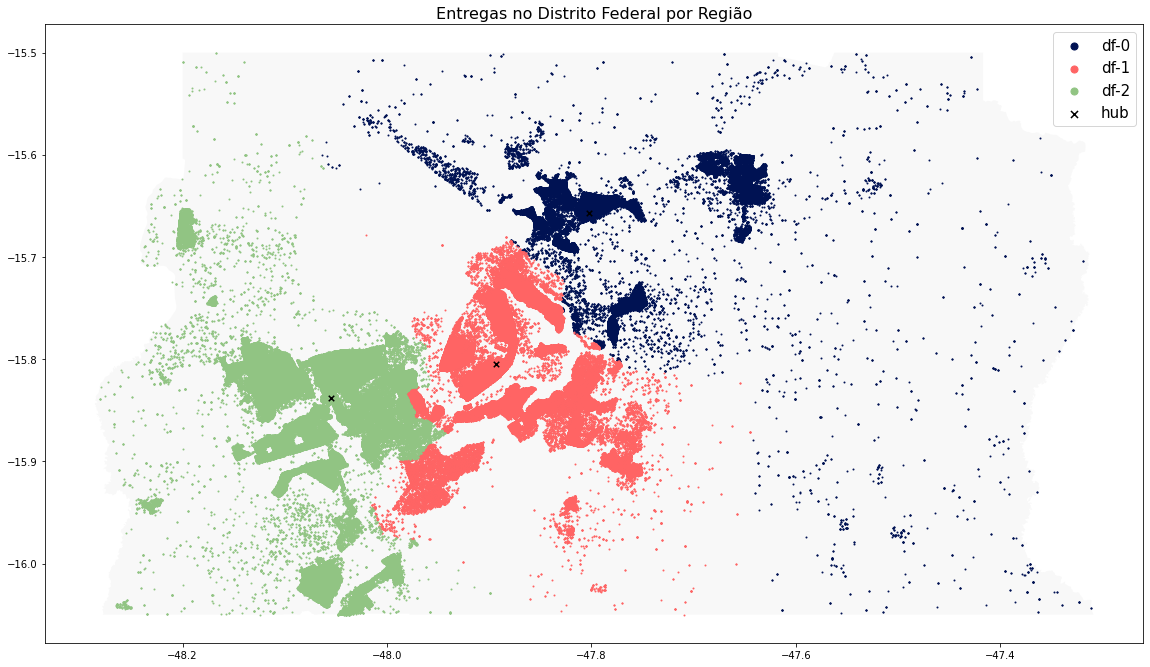

In [ ]:
import matplotlib.pyplot as plt

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="#EEEEEE")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="#001253", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="#FF6464", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="#91C483", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

 - **Insights**:

1. As entregas realizadas a partir do hub df-0 apresentam uma mpe 

### **5.2. Gráfico de entregas por região** 

 - **Agregação**:

In [ ]:
# Normalize retorna os valores relativos (proporcionais)
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


 - **Visualização**:

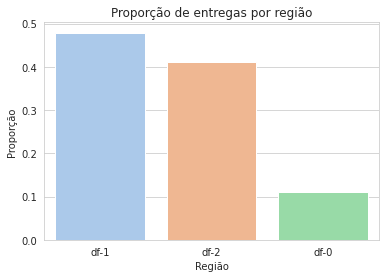

In [ ]:
import seaborn as sns

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

 - **Insights**:

1. A distribuição das **entregas** está muito concentrada nos **hubs** das regiões 1 e 2, mas pouco no da região 0. Contudo a capacidade dos veículos é mesma para todos os **hubs**, logo os **veículos** poderiam ser deslocados para as regiões de maior tráfego.